In [1]:
from dataset import Dataset
import vectorbt as vbt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest
from matplotlib.pyplot import figure

import warnings
warnings.simplefilter(action='ignore')
vbt.settings.set_theme('dark')

In [16]:
TICKER = 'BTCUSDT'
data_binance = Dataset().get_data(days=360, ticker=TICKER, ts='1h')

### creating features for a machine learning model

In [53]:
cols = []
data = data_binance.copy()
for i in range(0, 10):
    col = f'lag_{i}'
    # col_vol = f'lag_vol_{i}'
    cols.append(col)
    # cols.append(col_vol)
    data[col] = data['close'].pct_change().shift(i)
    # data[col_vol] = data['volume'].pct_change().shift(i)

### creating target variables

In [61]:
targets = []
for i in range(1, 5):
    target = f'y_{i}'
    targets.append(target)
    data[target] = data['close'].pct_change().shift(-i)
data = data.dropna()



#### Isolation Forest Algorithm.

Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [62]:
IF = IsolationForest(n_estimators=100, contamination=.03)
predictions = IF.fit_predict(data[cols[:2]])


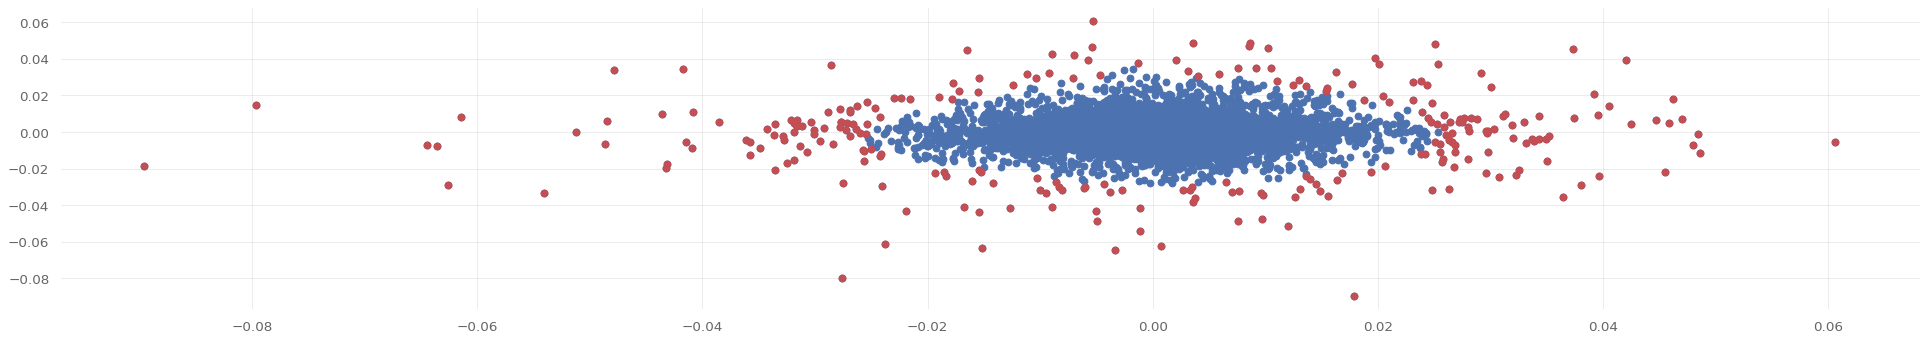

In [63]:
figure(figsize = (30, 5), dpi = 80)
outlier_index = np.where(predictions == -1)
values = data[cols[:2]].values[outlier_index]

plt.scatter(data[cols[0]].values, data[cols[1]].values)
plt.scatter(values[:, 0], values[:, 1], color='r')
plt.show()


In [64]:
data = data.reset_index()
data['outlier'] = False
data.loc[outlier_index[0], 'outlier'] = True
# data['outlier'] = np.where((data['outlier'] == True) & (data['lag_1'] > 0), True, False)
data = data.set_index('time')
data['outlier'].value_counts(True)

False    0.969961
True     0.030039
Name: outlier, dtype: float64

### Check ideas usings pandas

In [65]:
data.groupby(['outlier'])[targets].agg(['mean', 'sum'])

y_1                 y_2                 y_3                 y_4  \
             mean       sum      mean       sum      mean       sum      mean   
outlier                                                                         
False   -0.000039 -0.322699 -0.000050 -0.417120 -0.000017 -0.138468 -0.000006   
True     0.001198  0.310317  0.001602  0.414813  0.000478  0.123722  0.000124   

                   
              sum  
outlier            
False   -0.049955  
True     0.032081

In [59]:
pf_kwargs = dict(size=np.inf, freq='1h')
pf = vbt.Portfolio.from_signals(
    data['close'],
    np.where(data['outlier'] == True, True, False),
    np.where(data['outlier'].shift(1) == True, True, False),
    **pf_kwargs
)
pf.plot(height=400, width=1300).show()

In [60]:
pf.stats()

Start                               2021-03-23 11:00:00
End                                 2022-03-18 07:00:00
Period                                359 days 10:00:00
Start Value                                       100.0
End Value                                    117.406433
Total Return [%]                              17.406433
Benchmark Return [%]                         -25.476257
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                                15.6661
Max Drawdown Duration                 185 days 15:00:00
Total Trades                                        140
Total Closed Trades                                 140
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  52.142857
Best Trade [%]                                 9.552241
Worst Trade [%]                               -5